In [23]:
db_file = 'ted-talks/ted-talks.db'

OHCO = ['speaker', 'event', 'id', 'para_num', 'sent_num', 'token_num']
AUTHS = OHCO[:1]
BOOKS = OHCO[:2]
CHAPS = OHCO[:3]
PARAS = OHCO[:4]
SENTS = OHCO[:5]

BAG = CHAPS

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
import sqlite3
import pandas as pd
import numpy as np

import networkx as nx

In [48]:
ted_talks = pd.read_json('interactive-visual/ted-talks.json', orient='records').set_index('id')
view_range = (ted_talks["views"].min(), ted_talks["views"].max())
size_range = (5, 20)
ted_talks["views_z"] = ted_talks["views"].apply(lambda x: (x - view_range[0])*(size_range[1]-size_range[0])/(view_range[1]-view_range[0]) + size_range[0])
talks = docs.dropna().index.unique(level='id')

In [26]:
with sqlite3.connect(db_file) as db:  
    docs =  pd.read_sql('SELECT * FROM doc', db, index_col=CHAPS)

In [27]:
docs.dropna().head()

,,,transcript
speaker,event,id,
Crush Club,TED Salon: Radical Craft,35945,\nTC Milan: How you doing tonight? New York!\n...
JR,Torchbearers,13010,JR: Art is not supposed to change the world. B...
OK Go,TED2017,2792,\n\n\n\n\nYou know you can't keep letting it g...
Sauti Sol,TEDGlobal 2017,12803,\n Ooh ooh\nShe wants to be rich\nShe wants to...
A Tribe Called Red,TED2018,26265,\nWe are the tribe that they cannot see\nWe li...


In [28]:
documents = docs.dropna()["transcript"].tolist()
tfidf = TfidfVectorizer().fit_transform(documents)
pairwise_similarity = (tfidf * tfidf.T).A # no need to normalize, since Vectorizer will return normalized tf-idf

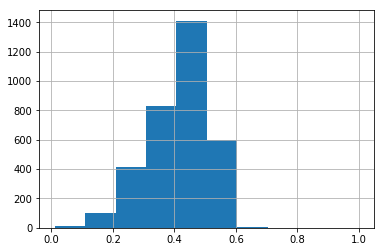

In [29]:
pd.DataFrame(pairwise_similarity)[1000].hist()

In [61]:
from tqdm import tqdm

sim_thresh = 0.75

E = []
vals = []
for i, row in tqdm(enumerate(pairwise_similarity)):
    for j, val in enumerate(row):
        if i == j: continue
        if val > sim_thresh and (j, i) not in E:
            E += [(talks[i], talks[j])]
            vals += [val]
            
nodes = list(set(j for i in E for j in i))

3367it [00:03, 975.87it/s] 


In [62]:
G=nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(E)

In [63]:
pos=nx.spring_layout(G)

In [64]:
# Nodes
Xv=[pos[k][0] for k in nodes] # range(pairwise_similarity.shape[0])
Yv=[pos[k][1] for k in nodes]
Tv = [ted_talks.loc[k,"headline"] for k in nodes]
Cv = [ted_talks.loc[k,"event"] for k in nodes]
Sv = [ted_talks.loc[k,"views_z"] for k in nodes]

In [65]:
# Edges
Xed=[]
Yed=[]
# Ted=[]
for i, j in E:
    Xed+=[pos[i][0],pos[j][0], None]
    Yed+=[pos[i][1],pos[j][1], None]
#     Ted+=[ted_talks.loc[talks[i],"headline"] + " <-> " + ted_talks.loc[talks[i],"headline"]]

Ced=Sed=vals

In [81]:
import plotly.plotly as py
from plotly.graph_objs import *

edges = Scatter(x=Xed,
                y=Yed,
                mode='lines',
                line=dict(
                    width=1,
                    color='#888'
                ),
#                 marker=dict(
# #                     size=Sed,
# #                     color=Ced
#                     showscale=True,
#                     # colorscale options
#                     #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
#                     #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
#                     #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
#                     colorscale='Greys',
#                     reversescale=True,
#                     color=Ced
#                 ),
                hoverinfo='none'
)

nodes = Scatter(x=Xv,
                y=Yv,
                text=Tv,
                mode='markers',
                hoverinfo='text',
                marker=dict(
                    showscale=True,
                    # colorscale options
                    #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
                    #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
                    #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
                    colorscale='Viridis',
                    reversescale=True,
                    color=Sv,
#                     size=Sv,
                    size=7,
                    colorbar=dict(
                        thickness=15,
                        title='# of Views',
                        xanchor='left',
                        titleside='right'
                    )
#                     ,line=dict(width=2)
                )
)

axis=dict(showline=False, # hide axis line, grid, ticklabels and  title
          zeroline=False,
          showgrid=False,
          showticklabels=False,
          title='' 
)

width=height=600
layout=Layout(title= "Top 100 most similar TED Talks",  
    font= dict(size=12),
    showlegend=False,
    autosize=False,
    width=width,
    height=height,
    xaxis=layout.XAxis(axis),
    yaxis=layout.YAxis(axis),          
#     margin=layout.Margin(
#         l=40,
#         r=40,
#         b=85,
#         t=100,
#     ),
    hovermode='closest'
)

data1=[edges, nodes]
fig1=Figure(data=data1, layout=layout)
py.iplot(fig1, filename='networkx')